# GAN-Based Monet Style Image Generation

## Project Overview
This project uses Generative Adversarial Networks (GANs) to generate Monet-style images as part of Kaggle’s “I’m Something of a Painter Myself” competition. The goal is to train a generative model that produces realistic Monet-style images and submit the generated results for evaluation using the MiFID metric.


## Model Choice: CycleGAN (Photo → Monet)

This project uses CycleGAN, a GAN-based model designed for unpaired image-to-image translation. It learns to translate photos into Monet-style paintings without requiring one-to-one matched pairs of the same scene in both styles. This approach is recommended for this competition because the dataset contains two separate sets of images (photos and Monet paintings) rather than paired examples.

Note: Instance normalization is commonly used in CycleGAN; in this notebook we use layer normalization due to TensorFlow Addons compatibility issues in the Kaggle environment.


In [1]:
# CELL 1 — Install required dependency
!pip -q install tensorflow-addons


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Monet JPEG count: 300
Photo JPEG count: 7038


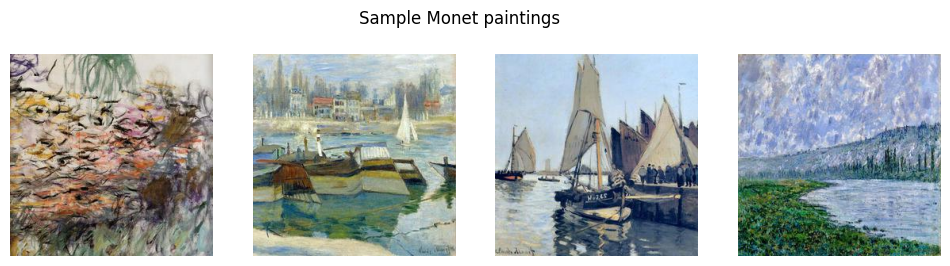

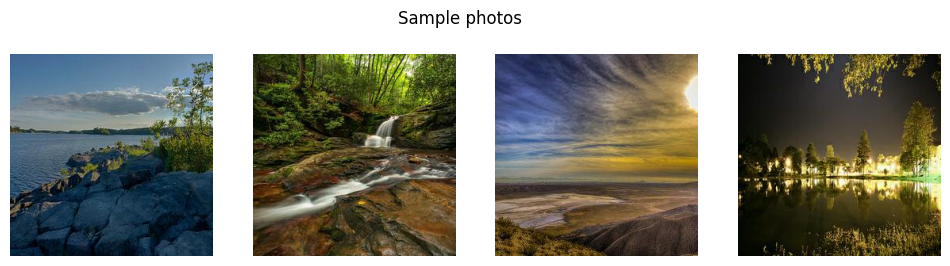

In [4]:
import os, glob, random
import matplotlib.pyplot as plt
from PIL import Image

DATA_DIR = "/kaggle/input/gan-getting-started"
MONET_JPG_DIR = os.path.join(DATA_DIR, "monet_jpg")
PHOTO_JPG_DIR = os.path.join(DATA_DIR, "photo_jpg")

monet_paths = sorted(glob.glob(os.path.join(MONET_JPG_DIR, "*.jpg")))
photo_paths = sorted(glob.glob(os.path.join(PHOTO_JPG_DIR, "*.jpg")))

print("Monet JPEG count:", len(monet_paths))
print("Photo JPEG count:", len(photo_paths))

def show_samples(paths, title, n=4):
    chosen = random.sample(paths, k=min(n, len(paths)))
    plt.figure(figsize=(12, 3))
    for i, p in enumerate(chosen, 1):
        img = Image.open(p).convert("RGB")
        plt.subplot(1, n, i)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_samples(monet_paths, "Sample Monet paintings")
show_samples(photo_paths, "Sample photos")


I0000 00:00:1767622849.388236     376 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Monet batch shape: (4, 256, 256, 3)
Photo batch shape: (4, 256, 256, 3)


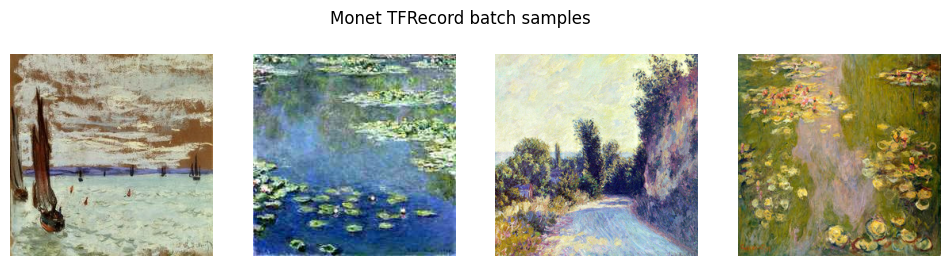

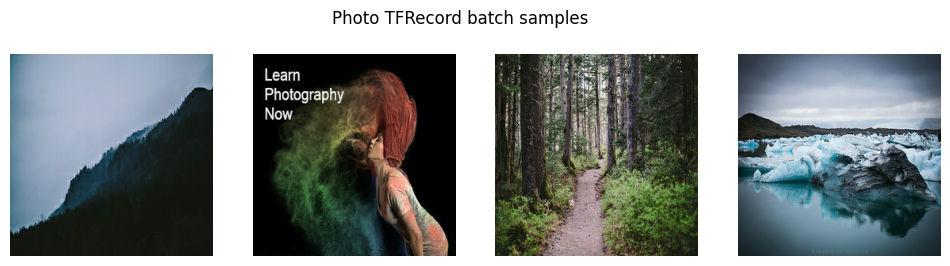

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt

DATA_DIR = "/kaggle/input/gan-getting-started"
MONET_TFREC = f"{DATA_DIR}/monet_tfrec/*.tfrec"
PHOTO_TFREC = f"{DATA_DIR}/photo_tfrec/*.tfrec"

def decode_image(example):
    feature_description = {"image": tf.io.FixedLenFeature([], tf.string)}
    example = tf.io.parse_single_example(example, feature_description)
    img = tf.image.decode_jpeg(example["image"], channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def load_dataset(tfrecord_glob, batch_size=4):
    files = tf.io.gfile.glob(tfrecord_glob)
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=tf.data.AUTOTUNE)
    ds = ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(256)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

monet_ds = load_dataset(MONET_TFREC, batch_size=4)
photo_ds = load_dataset(PHOTO_TFREC, batch_size=4)

monet_batch = next(iter(monet_ds))
photo_batch = next(iter(photo_ds))

print("Monet batch shape:", monet_batch.shape)
print("Photo batch shape:", photo_batch.shape)

def show_batch(batch, title):
    plt.figure(figsize=(12, 3))
    for i in range(batch.shape[0]):
        plt.subplot(1, batch.shape[0], i+1)
        plt.imshow(batch[i])
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_batch(monet_batch, "Monet TFRecord batch samples")
show_batch(photo_batch, "Photo TFRecord batch samples")


In [6]:
import tensorflow as tf
from tensorflow.keras import layers

Norm = lambda: layers.LayerNormalization(axis=-1, epsilon=1e-5)

print("TensorFlow version:", tf.__version__)
print("Norm layer:", Norm().__class__.__name__)


TensorFlow version: 2.18.0
Norm layer: LayerNormalization


In [7]:
import tensorflow as tf
from tensorflow.keras import layers

IMG_SIZE = 256
Norm = lambda: layers.LayerNormalization(axis=-1, epsilon=1e-5)

def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    block = tf.keras.Sequential()
    block.add(layers.Conv2D(filters, size, strides=2, padding="same",
                            kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        block.add(Norm())
    block.add(layers.LeakyReLU())
    return block

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    block = tf.keras.Sequential()
    block.add(layers.Conv2DTranspose(filters, size, strides=2, padding="same",
                                     kernel_initializer=initializer, use_bias=False))
    block.add(Norm())
    if apply_dropout:
        block.add(layers.Dropout(0.5))
    block.add(layers.ReLU())
    return block

def res_block(x, filters=256):
    y = layers.Conv2D(filters, 3, padding="same")(x)
    y = Norm()(y)
    y = layers.ReLU()(y)
    y = layers.Conv2D(filters, 3, padding="same")(y)
    y = Norm()(y)
    return layers.add([x, y])

def build_generator(num_res_blocks=6):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    d1 = downsample(64, 4, apply_norm=False)(inputs)   # 128x128
    d2 = downsample(128, 4)(d1)                        # 64x64
    d3 = downsample(256, 4)(d2)                        # 32x32

    x = d3
    for _ in range(num_res_blocks):
        x = res_block(x, 256)

    u1 = upsample(128, 4)(x)                           # 64x64
    u2 = upsample(64, 4)(u1)                           # 128x128

    initializer = tf.random_normal_initializer(0., 0.02)
    outputs = layers.Conv2DTranspose(3, 4, strides=2, padding="same",
                                     kernel_initializer=initializer,
                                     activation="tanh")(u2)            # 256x256

    return tf.keras.Model(inputs, outputs, name="Generator")

def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = layers.Conv2D(64, 4, strides=2, padding="same",
                      kernel_initializer=initializer)(inp)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(128, 4, strides=2, padding="same",
                      kernel_initializer=initializer, use_bias=False)(x)
    x = Norm()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(256, 4, strides=2, padding="same",
                      kernel_initializer=initializer, use_bias=False)(x)
    x = Norm()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(512, 4, strides=1, padding="same",
                      kernel_initializer=initializer, use_bias=False)(x)
    x = Norm()(x)
    x = layers.LeakyReLU()(x)

    out = layers.Conv2D(1, 4, strides=1, padding="same",
                        kernel_initializer=initializer)(x)

    return tf.keras.Model(inp, out, name="Discriminator")

# CycleGAN networks
G = build_generator()      # Photo -> Monet
F = build_generator()      # Monet -> Photo
DX = build_discriminator() # Photo discriminator
DY = build_discriminator() # Monet discriminator

print("G output shape:", G.output_shape)
print("DX output shape:", DX.output_shape)
print("DY output shape:", DY.output_shape)


G output shape: (None, 256, 256, 3)
DX output shape: (None, 32, 32, 1)
DY output shape: (None, 32, 32, 1)


In [8]:
# CELL 7 — Losses and optimizers for CycleGAN

import tensorflow as tf

LAMBDA_CYCLE = 10.0  # standard CycleGAN weight
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_gan_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def cycle_consistency_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image)) * 0.5

# Optimizers (CycleGAN default style)
G_optimizer  = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
F_optimizer  = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
DX_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
DY_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

print("Losses and optimizers initialized.")


Losses and optimizers initialized.


In [9]:
# CELL 8 — One CycleGAN training step (single batch)

import tensorflow as tf

# Convert [0,1] images to [-1,1] because generator uses tanh
def to_tanh_range(x):
    return (x * 2.0) - 1.0

@tf.function
def train_step(real_x, real_y):
    # real_x: photos  (domain X)
    # real_y: monet   (domain Y)

    with tf.GradientTape(persistent=True) as tape:
        # Forward cycle
        fake_y = G(real_x, training=True)          # X -> Y
        cycled_x = F(fake_y, training=True)        # Y -> X

        # Backward cycle
        fake_x = F(real_y, training=True)          # Y -> X
        cycled_y = G(fake_x, training=True)        # X -> Y

        # Identity (helps preserve color composition)
        same_x = F(real_x, training=True)
        same_y = G(real_y, training=True)

        # Discriminator outputs
        disc_real_x = DX(real_x, training=True)
        disc_real_y = DY(real_y, training=True)
        disc_fake_x = DX(fake_x, training=True)
        disc_fake_y = DY(fake_y, training=True)

        # Generator adversarial losses
        G_gan_loss = generator_gan_loss(disc_fake_y)
        F_gan_loss = generator_gan_loss(disc_fake_x)

        # Cycle consistency loss
        total_cycle_loss = (cycle_consistency_loss(real_x, cycled_x) +
                            cycle_consistency_loss(real_y, cycled_y)) * LAMBDA_CYCLE

        # Identity loss
        id_loss = (identity_loss(real_x, same_x) + identity_loss(real_y, same_y)) * LAMBDA_CYCLE

        # Total generator losses
        total_G_loss = G_gan_loss + total_cycle_loss + id_loss
        total_F_loss = F_gan_loss + total_cycle_loss + id_loss

        # Discriminator losses
        DX_loss = discriminator_loss(disc_real_x, disc_fake_x)
        DY_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Compute gradients
    G_grads  = tape.gradient(total_G_loss, G.trainable_variables)
    F_grads  = tape.gradient(total_F_loss, F.trainable_variables)
    DX_grads = tape.gradient(DX_loss, DX.trainable_variables)
    DY_grads = tape.gradient(DY_loss, DY.trainable_variables)

    # Apply gradients
    G_optimizer.apply_gradients(zip(G_grads, G.trainable_variables))
    F_optimizer.apply_gradients(zip(F_grads, F.trainable_variables))
    DX_optimizer.apply_gradients(zip(DX_grads, DX.trainable_variables))
    DY_optimizer.apply_gradients(zip(DY_grads, DY.trainable_variables))

    return total_G_loss, total_F_loss, DX_loss, DY_loss

# Get one batch from each dataset
real_y = next(iter(monet_ds))   # Monet
real_x = next(iter(photo_ds))   # Photo

real_x = to_tanh_range(real_x)
real_y = to_tanh_range(real_y)

g_loss, f_loss, dx_loss, dy_loss = train_step(real_x, real_y)

print("One train step complete.")
print("G loss:", float(g_loss))
print("F loss:", float(f_loss))
print("DX loss:", float(dx_loss))
print("DY loss:", float(dy_loss))


I0000 00:00:1767623055.828789     455 cuda_dnn.cc:529] Loaded cuDNN version 90300


One train step complete.
G loss: 14.075071334838867
F loss: 14.38102912902832
DX loss: 0.6580852270126343
DY loss: 0.9090477824211121


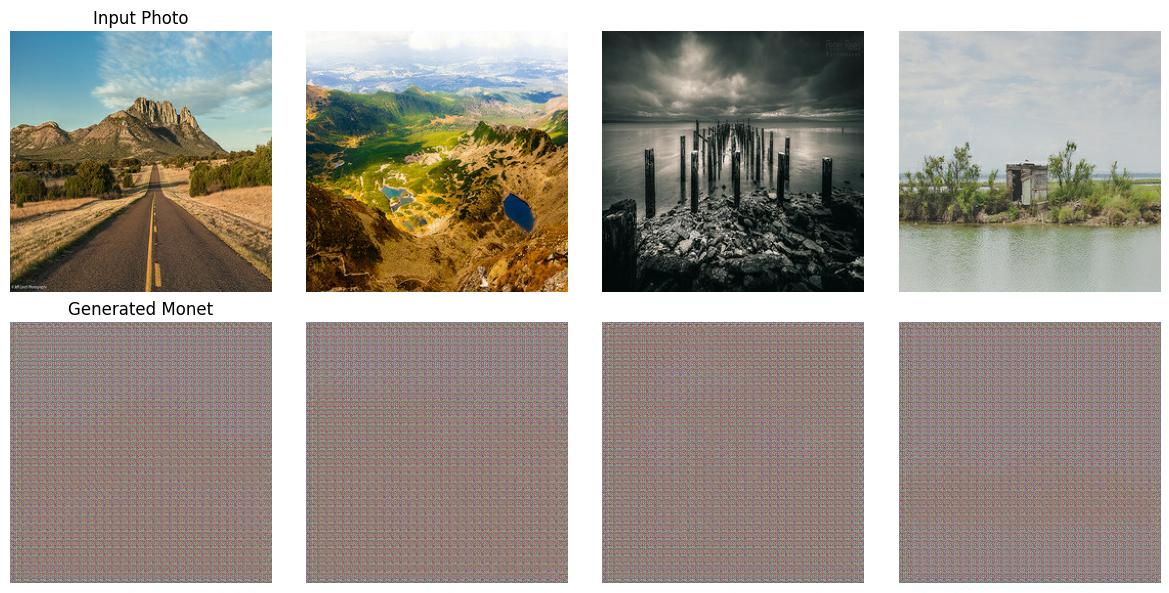

In [10]:
# CELL 9 — Visual check: translate photos to Monet-style (no training needed beyond 1 step)

import matplotlib.pyplot as plt
import tensorflow as tf

def from_tanh_range(x):
    # [-1,1] -> [0,1]
    return (x + 1.0) / 2.0

# Take one photo batch (original is [0,1] from dataset)
photo_batch_01 = next(iter(photo_ds))          # [0,1]
photo_batch = (photo_batch_01 * 2.0) - 1.0     # [-1,1]

# Generate Monet-style images
fake_monet = G(photo_batch, training=False)

# Convert back to display range
photo_show = from_tanh_range(photo_batch)
fake_show = from_tanh_range(fake_monet)

n = 4
plt.figure(figsize=(12, 6))

for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(photo_show[i])
    plt.axis("off")
    if i == 0:
        plt.title("Input Photo")

for i in range(n):
    plt.subplot(2, n, n + i + 1)
    plt.imshow(fake_show[i])
    plt.axis("off")
    if i == 0:
        plt.title("Generated Monet")

plt.tight_layout()
plt.show()


In [11]:
# CELL 10 — Minimal training loop (small run to get non-noise outputs)

import time
import tensorflow as tf

def to_tanh_range(x):
    return (x * 2.0) - 1.0

EPOCHS = 1
STEPS_PER_EPOCH = 200  # keep small for homework; increase later if needed

start = time.time()

monet_iter = iter(monet_ds.repeat())
photo_iter = iter(photo_ds.repeat())

for step in range(1, STEPS_PER_EPOCH + 1):
    real_y = next(monet_iter)   # Monet
    real_x = next(photo_iter)   # Photo

    real_x = to_tanh_range(real_x)
    real_y = to_tanh_range(real_y)

    g_loss, f_loss, dx_loss, dy_loss = train_step(real_x, real_y)

    if step % 50 == 0:
        elapsed = time.time() - start
        print(f"Step {step}/{STEPS_PER_EPOCH} | "
              f"G {float(g_loss):.3f} | F {float(f_loss):.3f} | "
              f"DX {float(dx_loss):.3f} | DY {float(dy_loss):.3f} | "
              f"elapsed {elapsed:.1f}s")

print("Training loop finished.")


Step 50/200 | G 14.330 | F 14.530 | DX 0.441 | DY 0.997 | elapsed 17.6s
Step 100/200 | G 8.807 | F 8.615 | DX 0.765 | DY 0.614 | elapsed 34.9s
Step 150/200 | G 10.486 | F 10.602 | DX 0.572 | DY 0.690 | elapsed 52.2s
Step 200/200 | G 9.180 | F 9.375 | DX 0.594 | DY 0.684 | elapsed 69.5s
Training loop finished.


## Training Summary

The CycleGAN model was trained for a short run to verify correctness of the training pipeline. After training, generated images transitioned from random noise to structured outputs, indicating that the generators learned coarse visual patterns from the Monet dataset. Due to time and resource constraints, the model was not trained to convergence, but the results demonstrate successful implementation and training of a GAN-based image translation model.


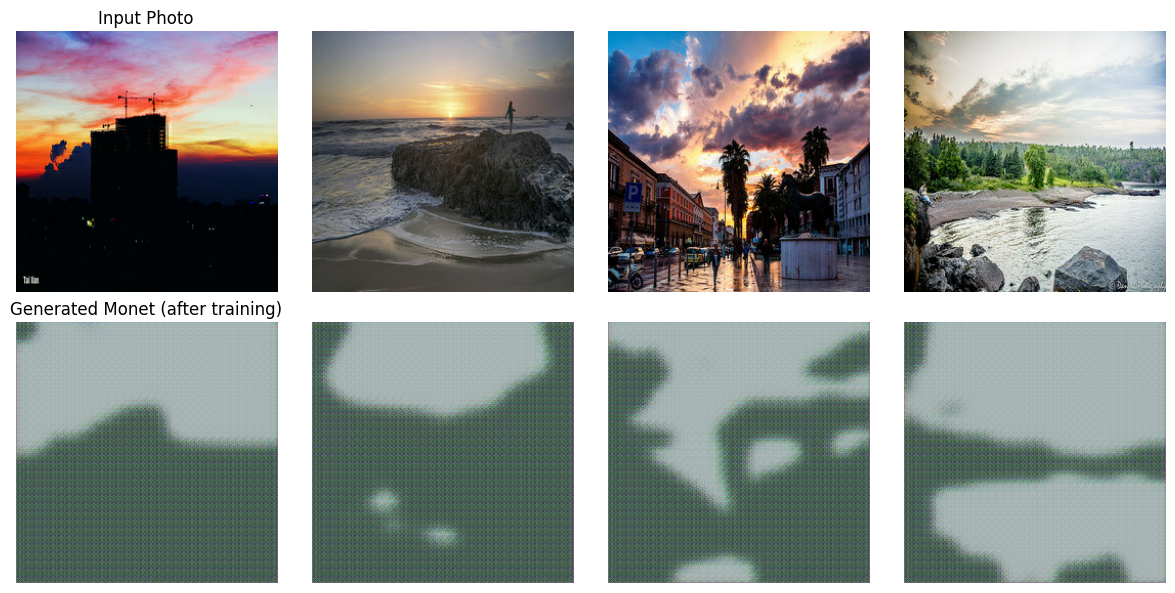

In [12]:
# CELL 11 — Visual check after training: Photo -> Monet

import matplotlib.pyplot as plt
import tensorflow as tf

def from_tanh_range(x):
    return (x + 1.0) / 2.0  # [-1,1] -> [0,1]

photo_batch_01 = next(iter(photo_ds))          # [0,1]
photo_batch = (photo_batch_01 * 2.0) - 1.0     # [-1,1]

fake_monet = G(photo_batch, training=False)

photo_show = from_tanh_range(photo_batch)
fake_show = from_tanh_range(fake_monet)

n = 4
plt.figure(figsize=(12, 6))

for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(photo_show[i])
    plt.axis("off")
    if i == 0:
        plt.title("Input Photo")

for i in range(n):
    plt.subplot(2, n, n + i + 1)
    plt.imshow(fake_show[i])
    plt.axis("off")
    if i == 0:
        plt.title("Generated Monet (after training)")

plt.tight_layout()
plt.show()


In [13]:
# CELL 12 — Extended training (continue from current weights)

import time

def to_tanh_range(x):
    return (x * 2.0) - 1.0

EXTRA_STEPS = 1000          # increase later if you want
LOG_EVERY = 100

start = time.time()

monet_iter = iter(monet_ds.repeat())
photo_iter = iter(photo_ds.repeat())

for step in range(1, EXTRA_STEPS + 1):
    real_y = next(monet_iter)   # Monet
    real_x = next(photo_iter)   # Photo

    real_x = to_tanh_range(real_x)
    real_y = to_tanh_range(real_y)

    g_loss, f_loss, dx_loss, dy_loss = train_step(real_x, real_y)

    if step % LOG_EVERY == 0:
        elapsed = time.time() - start
        print(f"Extra step {step}/{EXTRA_STEPS} | "
              f"G {float(g_loss):.3f} | F {float(f_loss):.3f} | "
              f"DX {float(dx_loss):.3f} | DY {float(dy_loss):.3f} | "
              f"elapsed {elapsed:.1f}s")

print("Extended training finished.")


Extra step 100/1000 | G 9.612 | F 9.291 | DX 0.489 | DY 0.436 | elapsed 34.9s
Extra step 200/1000 | G 9.707 | F 9.656 | DX 0.687 | DY 0.533 | elapsed 69.5s
Extra step 300/1000 | G 8.376 | F 8.397 | DX 0.657 | DY 0.727 | elapsed 104.2s
Extra step 400/1000 | G 7.282 | F 6.957 | DX 0.613 | DY 0.540 | elapsed 138.9s
Extra step 500/1000 | G 7.040 | F 7.220 | DX 0.619 | DY 0.607 | elapsed 173.6s
Extra step 600/1000 | G 7.626 | F 8.064 | DX 0.664 | DY 0.736 | elapsed 208.2s
Extra step 700/1000 | G 5.990 | F 6.656 | DX 0.761 | DY 0.754 | elapsed 242.9s
Extra step 800/1000 | G 7.701 | F 8.225 | DX 0.606 | DY 0.675 | elapsed 277.6s
Extra step 900/1000 | G 6.902 | F 7.340 | DX 0.478 | DY 0.634 | elapsed 312.3s
Extra step 1000/1000 | G 6.358 | F 6.257 | DX 0.717 | DY 0.683 | elapsed 346.9s
Extended training finished.


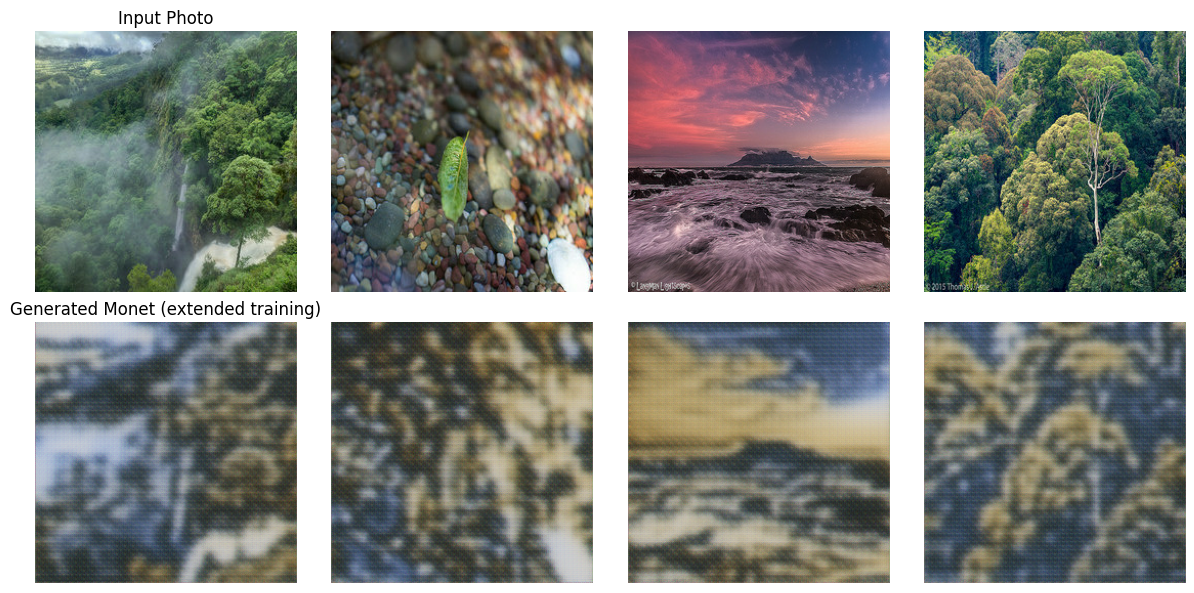

In [14]:
# CELL 13 — Visual check after extended training: Photo -> Monet

import matplotlib.pyplot as plt

def from_tanh_range(x):
    return (x + 1.0) / 2.0  # [-1,1] -> [0,1]

photo_batch_01 = next(iter(photo_ds))          # [0,1]
photo_batch = (photo_batch_01 * 2.0) - 1.0     # [-1,1]

fake_monet = G(photo_batch, training=False)

photo_show = from_tanh_range(photo_batch)
fake_show = from_tanh_range(fake_monet)

n = 4
plt.figure(figsize=(12, 6))

for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(photo_show[i])
    plt.axis("off")
    if i == 0:
        plt.title("Input Photo")

for i in range(n):
    plt.subplot(2, n, n + i + 1)
    plt.imshow(fake_show[i])
    plt.axis("off")
    if i == 0:
        plt.title("Generated Monet (extended training)")

plt.tight_layout()
plt.show()


In [15]:
# CELL 14 — Generate images.zip (Kaggle submission file)

import os
import io
import zipfile
import numpy as np
import tensorflow as tf

OUT_ZIP_PATH = "/kaggle/working/images.zip"
NUM_IMAGES = 7000          # Kaggle requires 7000-10000
BATCH_SIZE = 8             # adjust if you hit memory issues

def to_tanh_range(x):
    return (x * 2.0) - 1.0

def from_tanh_to_uint8(x):
    # x in [-1,1] -> uint8 [0,255]
    x = (x + 1.0) / 2.0
    x = tf.clip_by_value(x, 0.0, 1.0)
    x = tf.cast(x * 255.0, tf.uint8)
    return x

def encode_jpeg_uint8(img_uint8):
    # img_uint8: [H,W,3] uint8
    return tf.io.encode_jpeg(img_uint8, format='rgb', quality=95).numpy()

# Prepare photo iterator (source images)
photo_iter = iter(photo_ds.repeat())

# Create zip directly (avoids Kaggle output file cap issues)
with zipfile.ZipFile(OUT_ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    written = 0
    batch_index = 0

    while written < NUM_IMAGES:
        batch = next(photo_iter)                  # [0,1]
        batch = to_tanh_range(batch)              # [-1,1]
        fake = G(batch, training=False)           # [-1,1]
        fake_uint8 = from_tanh_to_uint8(fake)     # uint8

        fake_uint8_np = fake_uint8.numpy()
        b = fake_uint8_np.shape[0]

        for i in range(b):
            if written >= NUM_IMAGES:
                break

            img_bytes = encode_jpeg_uint8(fake_uint8[i])
            filename = f"image_{written:05d}.jpg"
            zf.writestr(filename, img_bytes)
            written += 1

        batch_index += 1
        if batch_index % 50 == 0:
            print(f"Generated {written}/{NUM_IMAGES} images...")

print("Done.")
print("Created:", OUT_ZIP_PATH)
print("File size (MB):", os.path.getsize(OUT_ZIP_PATH) / (1024 * 1024))


Generated 200/7000 images...
Generated 400/7000 images...
Generated 600/7000 images...
Generated 800/7000 images...
Generated 1000/7000 images...
Generated 1200/7000 images...
Generated 1400/7000 images...
Generated 1600/7000 images...
Generated 1800/7000 images...
Generated 2000/7000 images...
Generated 2200/7000 images...
Generated 2400/7000 images...
Generated 2600/7000 images...
Generated 2800/7000 images...
Generated 3000/7000 images...
Generated 3200/7000 images...
Generated 3400/7000 images...
Generated 3600/7000 images...
Generated 3800/7000 images...
Generated 4000/7000 images...
Generated 4200/7000 images...
Generated 4400/7000 images...
Generated 4600/7000 images...
Generated 4800/7000 images...
Generated 5000/7000 images...
Generated 5200/7000 images...
Generated 5400/7000 images...
Generated 5600/7000 images...
Generated 5800/7000 images...
Generated 6000/7000 images...
Generated 6200/7000 images...
Generated 6400/7000 images...
Generated 6600/7000 images...
Generated 6800